# Projeto Final  - Aprendizado de Máquina: Sentiment of Restaurants
### Giovanna Louzi Bellonia - 2017086015

Nesse projeto final, meu objetivo foi trabalhar com NLP, um das áreas dentro do aprendizado de máquina vistos em sala de aula que mais me chamou atenção. Achei muito interessante a idéia de ser possível interpretar textos e classificá-los, por ser algo que não parece ser tão óbvio quanto a classificação feita para dados numéricos.

Com esse objetivo, acabei me preocupando mais em entender como deve ser feito o processamento dos dados para utilizar um algoritmo de aprendizado que os classifique do que em achar o melhor algoritmo de classificação para esse tipo de dados.


As fontes usadas para a pesquisa desse trabalho foram:

https://www.kaggle.com/shub99/sentiment-analysis-data

https://towardsdatascience.com/how-to-use-nlp-in-python-a-practical-step-by-step-example-bd82ca2d2e1e

https://realpython.com/python-nltk-sentiment-analysis/

https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

https://ilumeo.com.br/todos-posts/2020/06/12/um-guia-para-pnl-processamento-de-linguagem-natural

https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

https://www.ti-enxame.com/pt/nlp/como-o-tf-idf-e-calculado-pelo-scikit-learn-tfidfvectorizer/824687531/

https://www.educative.io/edpresso/countvectorizer-in-python

### Importação das bibliotecas necessárias:

In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk import pos_tag
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 1. Leitura e pré-processamento dos dados:

## 1.1) Leitura dos dados
Primeiro foi lido o dataset e imprimido parte dele para uma visão geral dos dados.

Esses dados foram obtidos de uma base do kaggle, no link: https://www.kaggle.com/shub99/sentiment-analysis-data.

Os dados são reviews de pessoas que foram a restaurantes diversos. Essas reviews estão classificadas por Liked = 1 (a pessoa gostou do restaurante) e Liked = 0 (a pessoa não gostou do restaurante). Ao trabalhar com os dados percebi que a maioria das reviews eram bem curtas, tendo a maioria apenas uma frase.

O objetivo então com esses dados vai ser entender se uma frase passa um sentimento de positividade ou de negatividade a respeito de um restaurante.

In [2]:
df = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')

In [3]:
pd.options.display.max_colwidth = 150
df.head(20)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.,0
8,The fries were great too.,1
9,A great touch.,1


## 1.2) Distribuição dos dados
Para checar a distribuição nos dados, foi feito uma análise da quantidade de reviews existente para cada uma das classes. Podemos perceber que a distribuição dos dados é proporcional, sendo 500 de cada.

In [4]:
counter = df['Liked'].value_counts()
counter

1    500
0    500
Name: Liked, dtype: int64

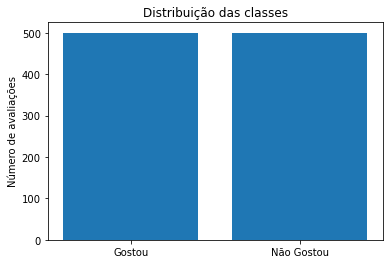

In [5]:
plt.bar(['Gostou', 'Não Gostou'], counter)
plt.title('Distribuição das classes')
plt.ylabel('Número de avaliações')
plt.show()

## 1.3) Pré-processamento dos dados
Para lidarmos com textos, é necessário fazer um pré-processamento dos dados para que alguns detalhes não atrapalhem na hora do aprendizado. A ideia é tentar normatizar ao máximo os textos, de forma que palavras que estão diferentes, mas que no fundo são a mesma coisa, sejam tratadas como iguais.

Por exemplo, "ele" e "Ele" são a mesma palavra mas uma está iniciada em minúsculo. Para resolver isso, todas as palavras foram passadas para minúsculo. Outro processo feito é a lematização, que transforma as palavras para sua forma do dicionário (lema). Tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra. Por exemplo, os verbos no tempo passado são alterados para presente (por exemplo, “foi” é alterado para “vai”) e os sinônimos são unificados (por exemplo, “melhor” é alterado para “bom”), padronizando palavras com significado semelhante à sua raiz. 

Outra etapa do pré-processamento é remover elementos do texto que não vão acrescentar nada por serem sempre muito comuns ou por não passarem muita informação. Esses elementos são as pontuações e os stopwords. Os stopwords são palavras muito comuns como artigos, pronomes e preposições.

### Função criada para se fazer a lematização:

In [6]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

### Stopwords da lingua inglesa:

In [7]:
english_stopwords = set(stopwords.words('english')) 
print(english_stopwords)

{'theirs', 'being', 'in', 'each', 'but', 'wasn', 're', 'himself', "mightn't", 'out', 'own', 'that', "she's", 'both', 'hasn', 't', "won't", 'haven', 'too', 'shouldn', 'above', 'were', "you're", 'not', 'doing', 'couldn', "hasn't", 'is', 'does', "it's", 'll', 'there', 'these', 'won', 'most', 'this', "that'll", 'i', 'my', 'no', 'm', 'from', "isn't", "wasn't", "hadn't", 'it', 'have', 'his', 'd', 'who', 'weren', 'should', "don't", 'between', "haven't", 'myself', 'at', 'mustn', 'than', "wouldn't", 'the', 'are', 'an', "doesn't", 'some', "weren't", 'ours', 'when', 'themselves', 'again', 'where', 'of', 'few', 'am', 'yourselves', 'until', 'needn', 'so', 'shan', 'hers', 'other', 'doesn', 'down', 'about', 'your', 'be', 'or', 'mightn', "needn't", "you'll", 'been', 'more', 'what', "shan't", 'nor', 'up', 'ain', 'further', 'yourself', 'through', 'her', 'wouldn', 'did', 'and', 'ma', 'don', 'below', 'he', 'had', 'why', 'didn', 'after', 'during', 'hadn', 'me', "aren't", 'o', 'will', "you've", 'do', 'with'

### Stopwords desconsiderando alguns termos que passam ideia de negação:

In [8]:
selected_stopwords = english_stopwords - set(['not', 'no', "mightn't", 'hadn', "don't", 'doesn', "aren't", "mustn't", 
                               'hasn', "needn't", "hadn't", 'aren', 'wouldn', "weren't", 'couldn', 'mustn',
                              'shouldn', "haven't", 'wasn', "shouldn't", "doesn't", "isn't", 'needn', 'isn', 
                               "didn't","won't", 'didn', 'weren', "wasn't", "couldn't"])
print(selected_stopwords)

{'theirs', 'being', 'in', 'each', 'but', 're', 'himself', 'out', 'own', 'that', "she's", 'both', 't', 'haven', 'too', 'above', 'were', "you're", 'doing', "hasn't", 'is', 'does', "it's", 'll', 'there', 'these', 'won', 'most', 'this', "that'll", 'i', 'my', 'm', 'from', 'it', 'have', 'his', 'd', 'who', 'should', 'between', 'myself', 'at', 'than', "wouldn't", 'the', 'are', 'an', 'some', 'ours', 'when', 'themselves', 'again', 'where', 'of', 'few', 'am', 'yourselves', 'until', 'so', 'shan', 'hers', 'other', 'down', 'about', 'your', 'be', 'or', 'mightn', "you'll", 'been', 'more', 'what', "shan't", 'nor', 'up', 'ain', 'further', 'yourself', 'through', 'her', 'did', 'and', 'ma', 'don', 'below', 'he', 'had', 'why', 'after', 'during', 'me', 'o', 'will', "you've", 'do', 'with', 'our', 'them', 'whom', 've', 'over', 'very', 'their', 'how', 'just', "you'd", 'then', 'such', 'which', 'into', 'on', 'only', 'under', 'we', 'yours', 'before', 'by', 'off', 'y', 'they', "should've", 'itself', 'you', 'has', '

### Exemplo de várias etapas de um pré-processamento em um review:

In [9]:
example = df.loc[18]
review = example['Review']

print('- Review original:')
print(review, end='\n\n')

review = review.lower()
print('- Review em minúsculo:')
print(review, end='\n\n')

review = word_tokenize(review)
print('- Review tokenizado:')
print(review, end='\n\n')

review = lemmatize_sentence(review)
print('- Review lematizado:')
print(review, end='\n\n')

review = [token for token in review if token not in english_stopwords]
print('- Review sem stop words:')
print(review, end='\n\n')

review = [w for w in review if w.isalpha()]
print('- Review sem pontuação')
print(review, end='\n\n')

- Review original:
This place is not worth your time, let alone Vegas.

- Review em minúsculo:
this place is not worth your time, let alone vegas.

- Review tokenizado:
['this', 'place', 'is', 'not', 'worth', 'your', 'time', ',', 'let', 'alone', 'vegas', '.']

- Review lematizado:
['this', 'place', 'be', 'not', 'worth', 'your', 'time', ',', 'let', 'alone', 'vega', '.']

- Review sem stop words:
['place', 'worth', 'time', ',', 'let', 'alone', 'vega', '.']

- Review sem pontuação
['place', 'worth', 'time', 'let', 'alone', 'vega']



### Função que faz o pré-processamento de uma string:

In [10]:
def clean_string(s, remove_stopwords=False, return_tokenized=False, remove_selected_stopwords=False):
    s = s.lower()
    s = word_tokenize(s)
    s = lemmatize_sentence(s)
    if remove_stopwords:
        s = [token for token in s if token not in english_stopwords]
    if remove_selected_stopwords:
        s = [token for token in s if token not in english_stopwords - selected_stopwords]
    s = [w for w in s if w.isalpha()]
    
    if return_tokenized:
        return s
    
    return ' '.join(s)

## 1.4) Frequência das palavras nos dados
Para entender um pouco mais sobre meus dados, e sobre a influência dos stop words na comparação entre os dois tipos de reviews (positivo e negativo) fiz uma avaliação da frequência de palavras para cada um dos tipos, já na intenção de procurar algum padrão que pudesse ajudar o classificador a definir se uma frase é positiva ou negativa.

In [11]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def print_frequency(cleaned_tokens_list, quant = 10):
    all_words = get_all_words(cleaned_tokens_list)
    freq_dist = FreqDist(all_words)
    print(freq_dist.most_common(quant))

In [12]:
positive_reviews = df.loc[df['Liked'] == 1]['Review']
negative_reviews = df.loc[df['Liked'] == 0]['Review']

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

positive_cleaned_tokens_list_with_stopwords = []
negative_cleaned_tokens_list_with_stopwords = []

for s in positive_reviews:
    positive_cleaned_tokens_list.append(clean_string(s, remove_stopwords=True, return_tokenized=True))
    positive_cleaned_tokens_list_with_stopwords.append(clean_string(s, return_tokenized=True))

for s in negative_reviews:
    negative_cleaned_tokens_list.append(clean_string(s, remove_stopwords=True, return_tokenized=True))
    negative_cleaned_tokens_list_with_stopwords.append(clean_string(s, return_tokenized=True))

### As 10 palavras mais frequentes das reviews positivas sem stopwords:

In [13]:
print_frequency(positive_cleaned_tokens_list)

[('good', 78), ('great', 70), ('place', 60), ('food', 60), ('service', 46), ('go', 30), ('love', 28), ('time', 26), ('friendly', 24), ('nice', 24)]


### As 10 palavras mais frequentes das reviews positivas com stopwords:

In [14]:
print_frequency(positive_cleaned_tokens_list_with_stopwords)

[('be', 349), ('the', 311), ('and', 222), ('i', 138), ('a', 112), ('to', 88), ('have', 80), ('good', 78), ('this', 77), ('great', 70)]


### As 10 palavras mais frequentes das reviews negativas sem stopwords:

In [15]:
print_frequency(negative_cleaned_tokens_list)

[('food', 66), ('place', 52), ('go', 47), ('back', 38), ('service', 38), ('get', 34), ('bad', 34), ('good', 33), ('like', 30), ('time', 29)]


### As 10 palavras mais frequentes das reviews negativas com stopwords:

In [16]:
print_frequency(negative_cleaned_tokens_list_with_stopwords)

[('be', 372), ('the', 274), ('i', 218), ('and', 170), ('to', 131), ('a', 125), ('not', 99), ('it', 90), ('of', 74), ('have', 71)]


### Wordcloud:

Uma outra forma de ver a frequência das palavras dentre cada categoria é utilizando os wordclouds:

In [17]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

def show_wordcloud_reviews(reviews):
    cleaned_tokens_list = []

    for s in reviews:
        cleaned_tokens_list.append(clean_string(s))

    show_wordcloud(' '.join(cleaned_tokens_list))

### Wordcloud das reviews positivas:

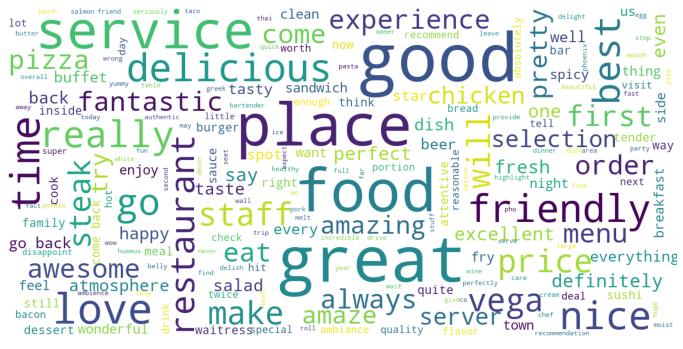

In [18]:
positive_reviews = df.loc[df['Liked'] == 1]['Review']
show_wordcloud_reviews(positive_reviews)

### Wordcloud das reviews negativas:

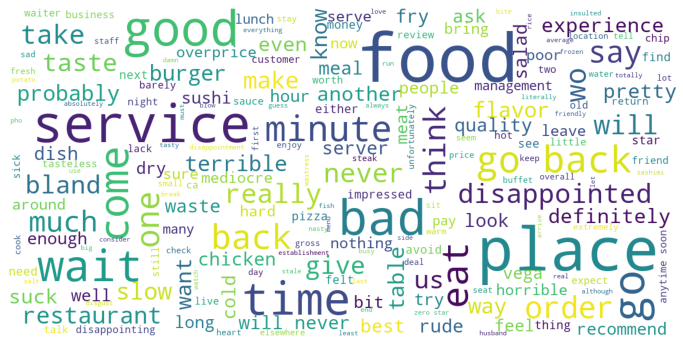

In [19]:
negative_reviews = df.loc[df['Liked'] == 0]['Review']
show_wordcloud_reviews(negative_reviews)

Com essa análise de frequência podemos perceber que algumas palavras são frequentes nas duas categorias, como 'good' e 'food'. E, quando analisamos a frequência das palavras com stopwords, como esperado, não há uma diferenciação entre as palavras de reviews positivas e de negativas. Entretanto, se destaca a palavra 'not', que aparece em grande quantidade nas reviews negativas.

# 2) Classificação dos dados

Como dito no início do notebook, meu objetivo com esse trabalho foi entender um pouco sobre o comportamento de dados linguísticos de acordo com a forma com que são tratados. Por isso, testei a influência da remoção ou não de stopwords na parte do pré-processamento dos dados. Também fiz a remoção apenas de stopwords que não remetessem a ideia de negatividade, para checar se as vezes mantendo stopwords negativas iria facilitar a detecção de reviews negativas.

Além disso, usei duas formas diferentes de transformar os dados de texto para numérico, usando o TfidfVectorizer e o CountVectorizer do sklearn.

O CountVectorizer retorna um vetor que faz uma contagem de quantas vezes as palavras presentes na frase aparecem nela. Algo como na imagem abaixo:
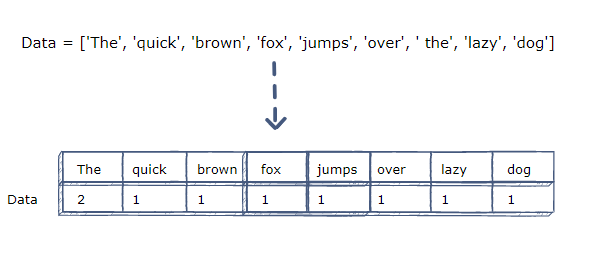

Já o TfidfVectorizer tem uma ideia parecida de fazer as sentenças virarem um vetor de números, mas a diferença é que palavras que aparecem menos tem um peso maior, ou seja, são definidas como mais relevantes. Além disso, o TfidfVectorizer considera as palavras que aparecem em todos os dados, não apenas um a um.

### Função train_models:

Essa função faz o treinamento dos diferentes modelos definidos dado um X e y e uma semente aleatória (seed) que vai fazer o split de X e y em treino e teste. 

Ela retorna um dict com as acurácias, predições e o valor real do y de teste.

In [20]:
def train_models(X, y, seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=seed)

    vectorizers = {}
    vectorizers['Tfidf'] = TfidfVectorizer().fit(X_train)
    vectorizers['Count'] = CountVectorizer().fit(X_train)

    classifiers = {}
    classifiers['SVC'] = SVC()
    classifiers['DecisionTree'] = DecisionTreeClassifier()
    classifiers['NaiveBayes'] = GaussianNB()
    classifiers['GradientTreeBoosting'] = GradientBoostingClassifier()
    classifiers['RandomForest'] = RandomForestClassifier()
    classifiers['LogisticRegression'] = LogisticRegression()

    accuracies = {}
    predictions = {}

    for vec in vectorizers:
        for model in classifiers:
            if model == 'NaiveBayes':
                classifiers[model].fit(vectorizers[vec].transform(X_train).todense(), y_train)
                preds = classifiers[model].predict(vectorizers[vec].transform(X_test).todense())
            else: 
                classifiers[model].fit(vectorizers[vec].transform(X_train), y_train)
                preds = classifiers[model].predict(vectorizers[vec].transform(X_test))
            
            print(f"Modelo: {model}, Vec: {vec}")
            print("Acurácia:", accuracy_score(preds, y_test))
            
            predictions[f'{model}-{vec}'] = preds
            accuracies[f'{model}-{vec}'] = accuracy_score(preds, y_test)
            
    return accuracies, predictions, y_test

A célula abaixo inicializa os dicts que serão utilizados para guardar os valores testados.

In [21]:
random_seeds = [0, 23, 42]
experiments_accuracies = {}
experiments_predictions = {}
experiments_ground_truth = {}

for i in range(len(random_seeds)):
    experiments_accuracies[i] = {}
    experiments_predictions[i] = {}
    experiments_ground_truth[i] = {}

### Classificação dos dados com Stopwords:

In [22]:
X = df['Review'].apply(clean_string).values
y = df['Liked'].values

for i in range(len(random_seeds)):
    accuracies, predictions, ground_truth = train_models(X, y, random_seeds[i])    
    experiments_accuracies[i]['With Stopwords'] =  accuracies
    experiments_predictions[i]['With Stopwords'] =  predictions
    experiments_ground_truth[i]['With Stopwords'] =  ground_truth

Modelo: SVC, Vec: Tfidf
Acurácia: 0.83
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.735
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.71
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.76
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.75
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.82
Modelo: SVC, Vec: Count
Acurácia: 0.805
Modelo: DecisionTree, Vec: Count
Acurácia: 0.7
Modelo: NaiveBayes, Vec: Count
Acurácia: 0.71
Modelo: GradientTreeBoosting, Vec: Count
Acurácia: 0.74
Modelo: RandomForest, Vec: Count
Acurácia: 0.78
Modelo: LogisticRegression, Vec: Count
Acurácia: 0.805
Modelo: SVC, Vec: Tfidf
Acurácia: 0.82
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.735
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.665
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.785
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.78
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.795
Modelo: SVC, Vec: Count
Acurácia: 0.785
Modelo: DecisionTree, Vec: Count
Acurácia: 0.75
Modelo: NaiveBayes, Vec: Count
Ac

### Classificação dos dados sem Stopwords:

In [23]:
X = df['Review'].apply(clean_string,remove_stopwords=True).values
y = df['Liked'].values

for i in range(len(random_seeds)):
    accuracies, predictions, ground_truth = train_models(X, y, random_seeds[i])    
    experiments_accuracies[i]['Without Stopwords'] =  accuracies
    experiments_predictions[i]['Without Stopwords'] =  predictions
    experiments_ground_truth[i]['Without Stopwords'] =  ground_truth

Modelo: SVC, Vec: Tfidf
Acurácia: 0.745
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.705
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.705
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.69
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.69
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.755
Modelo: SVC, Vec: Count
Acurácia: 0.73
Modelo: DecisionTree, Vec: Count
Acurácia: 0.705
Modelo: NaiveBayes, Vec: Count
Acurácia: 0.71
Modelo: GradientTreeBoosting, Vec: Count
Acurácia: 0.72
Modelo: RandomForest, Vec: Count
Acurácia: 0.74
Modelo: LogisticRegression, Vec: Count
Acurácia: 0.735
Modelo: SVC, Vec: Tfidf
Acurácia: 0.805
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.73
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.66
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.735
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.75
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.795
Modelo: SVC, Vec: Count
Acurácia: 0.775
Modelo: DecisionTree, Vec: Count
Acurácia: 0.675
Modelo: NaiveBayes, Vec: Coun

### Classificação dos dados sem algumas Stopwords (que não remetem ideia de negação):

In [24]:
X = df['Review'].apply(clean_string,remove_selected_stopwords=True).values
y = df['Liked'].values

for i in range(len(random_seeds)):
    accuracies, predictions, ground_truth = train_models(X, y, random_seeds[i])    
    experiments_accuracies[i]['Without Selected Stopwords'] =  accuracies
    experiments_predictions[i]['Without Selected Stopwords'] =  predictions
    experiments_ground_truth[i]['Without Selected Stopwords'] =  ground_truth

Modelo: SVC, Vec: Tfidf
Acurácia: 0.805
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.645
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.71
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.69
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.68
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.78
Modelo: SVC, Vec: Count
Acurácia: 0.755
Modelo: DecisionTree, Vec: Count
Acurácia: 0.685
Modelo: NaiveBayes, Vec: Count
Acurácia: 0.71
Modelo: GradientTreeBoosting, Vec: Count
Acurácia: 0.695
Modelo: RandomForest, Vec: Count
Acurácia: 0.74
Modelo: LogisticRegression, Vec: Count
Acurácia: 0.76
Modelo: SVC, Vec: Tfidf
Acurácia: 0.805
Modelo: DecisionTree, Vec: Tfidf
Acurácia: 0.695
Modelo: NaiveBayes, Vec: Tfidf
Acurácia: 0.665
Modelo: GradientTreeBoosting, Vec: Tfidf
Acurácia: 0.73
Modelo: RandomForest, Vec: Tfidf
Acurácia: 0.725
Modelo: LogisticRegression, Vec: Tfidf
Acurácia: 0.77
Modelo: SVC, Vec: Count
Acurácia: 0.73
Modelo: DecisionTree, Vec: Count
Acurácia: 0.73
Modelo: NaiveBayes, Vec: Count


## 3) Resultado dos experimentos

Com os experimentos feitos, pôde-se perceber que, de forma geral, os modelos foram melhores ao utilizarem dos dados com Stopwords.

Além disso, percebe-se que o Tfidf tende a ser melhor que o Count.

Uma possível explicação para esse resultado, é o fato de as reviews serem curtas, o que faz com que as stopwords não atrapalhem tanto na classificação, podendo até ajudar um pouco. Mas, como esperado, as stopwords não são tão relevantes quanto outros tipos de palavras, e, por isso, os modelos que utilizaram com Tfidf vão ser melhores pois vão levar em conta essa menor relevância dos stopwords, mas também de palavras que não são stopwords, como 'good', 'food' e 'service' que vimos no wordcloud.

In [34]:
def highlight_max(row, props):
    return np.where(row == np.max(row.values), props, '')

df_1 = pd.DataFrame(experiments_accuracies[0])
df_1.sort_index().style.apply(highlight_max, props='color:white;background-color:#F0765C;', axis=1)

,With Stopwords,Without Stopwords,Without Selected Stopwords
DecisionTree-Count,0.700000,0.705000,0.685000
DecisionTree-Tfidf,0.735000,0.705000,0.645000
GradientTreeBoosting-Count,0.740000,0.720000,0.695000
GradientTreeBoosting-Tfidf,0.760000,0.690000,0.690000
LogisticRegression-Count,0.805000,0.735000,0.760000
LogisticRegression-Tfidf,0.820000,0.755000,0.780000
NaiveBayes-Count,0.710000,0.710000,0.710000
NaiveBayes-Tfidf,0.710000,0.705000,0.710000
RandomForest-Count,0.780000,0.740000,0.740000
RandomForest-Tfidf,0.750000,0.690000,0.680000


In [29]:
df_2 = pd.DataFrame(experiments_accuracies[1])
df_2.style.apply(highlight_max, props='color:white;background-color:#F0765C;', axis=1)

,With Stopwords,Without Stopwords,Without Selected Stopwords
SVC-Tfidf,0.820000,0.805000,0.805000
DecisionTree-Tfidf,0.735000,0.730000,0.695000
NaiveBayes-Tfidf,0.665000,0.660000,0.665000
GradientTreeBoosting-Tfidf,0.785000,0.735000,0.730000
RandomForest-Tfidf,0.780000,0.750000,0.725000
LogisticRegression-Tfidf,0.795000,0.795000,0.770000
SVC-Count,0.785000,0.775000,0.730000
DecisionTree-Count,0.750000,0.675000,0.730000
NaiveBayes-Count,0.665000,0.665000,0.665000
GradientTreeBoosting-Count,0.740000,0.720000,0.720000


In [30]:
df_3 = pd.DataFrame(experiments_accuracies[2])
df_3.style.apply(highlight_max, props='color:white;background-color:#F0765C;', axis=1)

,With Stopwords,Without Stopwords,Without Selected Stopwords
SVC-Tfidf,0.820000,0.750000,0.770000
DecisionTree-Tfidf,0.700000,0.690000,0.700000
NaiveBayes-Tfidf,0.695000,0.700000,0.695000
GradientTreeBoosting-Tfidf,0.760000,0.725000,0.710000
RandomForest-Tfidf,0.765000,0.725000,0.715000
LogisticRegression-Tfidf,0.805000,0.740000,0.740000
SVC-Count,0.735000,0.725000,0.720000
DecisionTree-Count,0.705000,0.680000,0.690000
NaiveBayes-Count,0.660000,0.665000,0.660000
GradientTreeBoosting-Count,0.755000,0.735000,0.720000


Percebemos que remover apenas os stopwords sem ideia de negação não fez muita diferença:

In [33]:
df_1_without = pd.DataFrame(experiments_accuracies[0])
df_1_without = df_1_without[['Without Stopwords', 'Without Selected Stopwords']].sort_index()
df_1_without.style.apply(highlight_max, props='color:white;background-color:#F0765C;', axis=1)

,Without Stopwords,Without Selected Stopwords
DecisionTree-Count,0.705000,0.685000
DecisionTree-Tfidf,0.705000,0.645000
GradientTreeBoosting-Count,0.720000,0.695000
GradientTreeBoosting-Tfidf,0.690000,0.690000
LogisticRegression-Count,0.735000,0.760000
LogisticRegression-Tfidf,0.755000,0.780000
NaiveBayes-Count,0.710000,0.710000
NaiveBayes-Tfidf,0.705000,0.710000
RandomForest-Count,0.740000,0.740000
RandomForest-Tfidf,0.690000,0.680000


E que o SVM usando o Tfidf foi sempre o com melhor resultado, seguido do modelo de regressão linear:

In [35]:
df_1.nlargest(n=5, columns=['With Stopwords'])

,With Stopwords,Without Stopwords,Without Selected Stopwords
SVC-Tfidf,0.830,0.745,0.805
LogisticRegression-Tfidf,0.820,0.755,0.780
SVC-Count,0.805,0.730,0.755
LogisticRegression-Count,0.805,0.735,0.760
RandomForest-Count,0.780,0.740,0.740


In [36]:
df_2.nlargest(n=5, columns=['With Stopwords'])

,With Stopwords,Without Stopwords,Without Selected Stopwords
SVC-Tfidf,0.820,0.805,0.805
LogisticRegression-Count,0.800,0.795,0.770
LogisticRegression-Tfidf,0.795,0.795,0.770
GradientTreeBoosting-Tfidf,0.785,0.735,0.730
SVC-Count,0.785,0.775,0.730


In [37]:
df_3.nlargest(n=5, columns=['With Stopwords'])

,With Stopwords,Without Stopwords,Without Selected Stopwords
SVC-Tfidf,0.820,0.750,0.770
LogisticRegression-Count,0.815,0.750,0.740
LogisticRegression-Tfidf,0.805,0.740,0.740
RandomForest-Count,0.770,0.735,0.710
RandomForest-Tfidf,0.765,0.725,0.715


## 3.1) Experimento extra
Nesse experimento eu tentei utilizar a ideia da técnica de ensemble, em uma tentativa de verificar se era possível que os modelos diferentes aprendessem de formas diferentes, e, ao levar para uma votação, conseguissem aumentar a acurácia.

Entretando, não surpreendentemente, isso não funcionou. Já que a técnica de ensemble pede modelos mais fracos, o que não é o caso desses modelos treinados.

In [38]:
preds_list = [
    experiments_predictions[0]['With Stopwords'][model]
    for model in df_1.nlargest(n=5, columns=['With Stopwords']).index
]

preds_ensemble = np.median(np.array(preds_list), axis=0).astype(int)
print("Predições: {}\n".format(preds_ensemble))
print("Ground Truth: {}\n".format(experiments_ground_truth[0]['With Stopwords']))
print("Acurácia:", accuracy_score(preds_ensemble, experiments_ground_truth[0]['With Stopwords']))

Predições: [0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0
 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1
 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0
 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1
 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1]

Ground Truth: [0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1
 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1
 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1
 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1]

Acurácia: 0.82


In [39]:
preds_list = [
    experiments_predictions[1]['With Stopwords'][model]
    for model in df_2.nlargest(n=5, columns=['With Stopwords']).index
]

preds_ensemble = np.median(np.array(preds_list), axis=0).astype(int)
print("Predições: {}\n".format(preds_ensemble))
print("Ground Truth: {}\n".format(experiments_ground_truth[1]['With Stopwords']))
print("Acurácia:", accuracy_score(preds_ensemble, experiments_ground_truth[1]['With Stopwords']))

Predições: [1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1
 0 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0
 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1
 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0
 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1]

Ground Truth: [1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1
 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1
 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 1
 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0]

Acurácia: 0.795


In [40]:
preds_list = [
    experiments_predictions[2]['With Stopwords'][model]
    for model in df_3.nlargest(n=5, columns=['With Stopwords']).index
]

preds_ensemble = np.median(np.array(preds_list), axis=0).astype(int)
print("Predições: {}\n".format(preds_ensemble))
print("Ground Truth: {}\n".format(experiments_ground_truth[2]['With Stopwords']))
print("Acurácia:", accuracy_score(preds_ensemble, experiments_ground_truth[2]['With Stopwords']))

Predições: [1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1
 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0
 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1
 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 0 0
 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0
 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1]

Ground Truth: [1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1
 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 1
 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0
 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1]

Acurácia: 0.805
